Importação das Bibliotecas e Carregamento dos Dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Carregar a base de dados Iris
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
df = pd.read_csv(url)

# Mapear as classes para números
df['species'] = df['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2})

# Separar as variáveis preditivas e a variável alvo
X = df.drop(columns=['species']).values
y = df['species'].values

# Dividir em conjuntos de treinamento e teste (70% treinamento, 30% teste)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Implementação do MLP com uma Camada Oculta

Epoch 1/100 - Loss: 0.5459 - Accuracy: 0.3214 - Val Loss: 0.4065 - Val Accuracy: 0.4762
Epoch 2/100 - Loss: 0.5028 - Accuracy: 0.3690 - Val Loss: 0.3895 - Val Accuracy: 0.6190
Epoch 3/100 - Loss: 0.4720 - Accuracy: 0.6071 - Val Loss: 0.3796 - Val Accuracy: 0.7619
Epoch 4/100 - Loss: 0.4510 - Accuracy: 0.5714 - Val Loss: 0.3718 - Val Accuracy: 0.6667
Epoch 5/100 - Loss: 0.4333 - Accuracy: 0.5357 - Val Loss: 0.3648 - Val Accuracy: 0.5714
Epoch 6/100 - Loss: 0.4181 - Accuracy: 0.5357 - Val Loss: 0.3576 - Val Accuracy: 0.6190
Epoch 7/100 - Loss: 0.4031 - Accuracy: 0.4048 - Val Loss: 0.3541 - Val Accuracy: 0.4286
Epoch 8/100 - Loss: 0.3906 - Accuracy: 0.3571 - Val Loss: 0.3513 - Val Accuracy: 0.3810
Epoch 9/100 - Loss: 0.3792 - Accuracy: 0.3214 - Val Loss: 0.3489 - Val Accuracy: 0.3810
Epoch 10/100 - Loss: 0.3721 - Accuracy: 0.3571 - Val Loss: 0.3459 - Val Accuracy: 0.3810
Epoch 11/100 - Loss: 0.3643 - Accuracy: 0.3452 - Val Loss: 0.3451 - Val Accuracy: 0.3810
Epoch 12/100 - Loss: 0.3585 - 

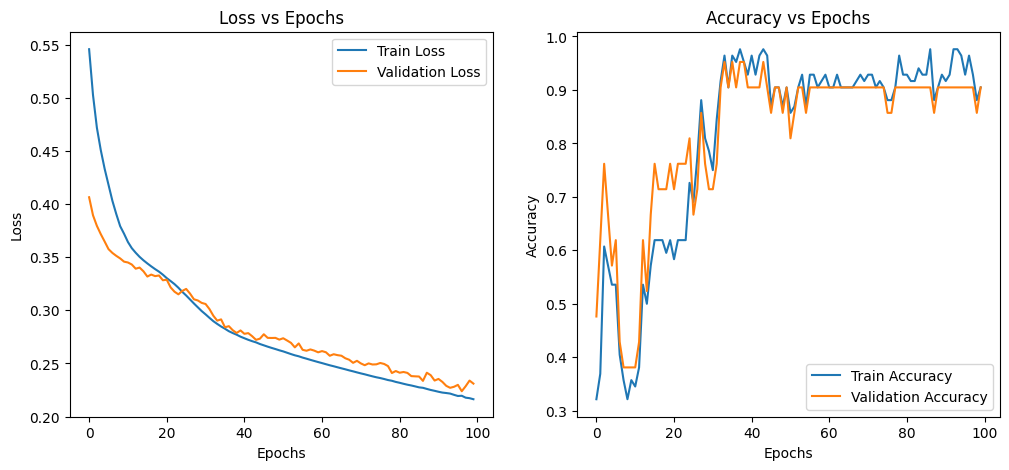

In [2]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, batch_size=16):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.weights1 = np.random.randn(input_size, hidden_size)
        self.weights2 = np.random.randn(hidden_size, output_size)
        self.bias1 = np.zeros((1, hidden_size))
        self.bias2 = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
         return x * (1 - x)

    def softmax(self, x):
      exp_x = np.exp(x -np.max(x, axis=1, keepdims=True))
      return exp_x / np.sum(exp_x, axis= 1, keepdims=True )

    def cross_entropy_loss(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred + 1e-9))

    def one_hot_encode(self, y):
        one_hot = np.zeros((y.size, self.output_size))
        one_hot[np.arange(y.size), y] = 1
        return one_hot

    def forward(self, X):
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def backward(self, X, y, output):
        y_one_hot = self.one_hot_encode(y)
        loss_gradient = output - y_one_hot
        d_weights2 = np.dot(self.a1.T, loss_gradient) / X.shape[0]
        d_bias2 = np.sum(loss_gradient, axis=0, keepdims=True) / X.shape[0]

        d_hidden_layer = np.dot(loss_gradient, self.weights2.T) * self.sigmoid_derivative(self.a1)
        d_weights1 = np.dot(X.T, d_hidden_layer) / X.shape[0]
        d_bias1 = np.sum(d_hidden_layer, axis=0, keepdims=True) / X.shape[0]

        # Atualizar pesos e bias
        self.weights1 -= self.learning_rate * d_weights1
        self.bias1 -= self.learning_rate * d_bias1
        self.weights2 -= self.learning_rate * d_weights2
        self.bias2 -= self.learning_rate * d_bias2

    def train(self, X_train, y_train, X_val, y_val, epochs=100):
        train_loss = []
        val_loss = []
        train_accuracy = []
        val_accuracy = []

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for i in range(0, X_train.shape[0], self.batch_size):
                X_batch = X_train[i:i + self.batch_size]
                y_batch = y_train[i:i + self.batch_size]

                output = self.forward(X_batch)
                self.backward(X_batch, y_batch, output)

            # Calculate the loss and accuracy for training and validation sets
            train_output = self.forward(X_train)
            val_output = self.forward(X_val)

            train_loss.append(self.cross_entropy_loss(self.one_hot_encode(y_train), train_output))
            val_loss.append(self.cross_entropy_loss(self.one_hot_encode(y_val), val_output))

            train_pred = np.argmax(train_output, axis=1)
            val_pred = np.argmax(val_output, axis=1)

            train_accuracy.append(np.mean(train_pred == y_train))
            val_accuracy.append(np.mean(val_pred == y_val))

            print(f'Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f} - Accuracy: {train_accuracy[-1]:.4f} - Val Loss: {val_loss[-1]:.4f} - Val Accuracy: {val_accuracy[-1]:.4f}')

        return train_loss, val_loss, train_accuracy, val_accuracy

# Dividir o conjunto de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Instanciar e treinar o MLP
mlp = MLP(input_size=4, hidden_size=10, output_size=3, learning_rate=0.01, batch_size=16)
train_loss, val_loss, train_accuracy, val_accuracy = mlp.train(X_train, y_train, X_val, y_val, epochs=100)

# Plotar as curvas de perda e acurácia
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Otimização de Hiperparâmetros com Grid Search

In [ ]:
from itertools import product

hidden_sizes = [5, 10, 20]
learning_rates = [0.001, 0.01, 0.1]
best_params = {}
best_val_accuracy = 0

for hidden_size, learning_rate in product(hidden_sizes, learning_rates):
    mlp = MLP(input_size=4, hidden_size=hidden_size, output_size=3, learning_rate=learning_rate, batch_size=16)
    _, _, _, val_accuracy = mlp.train(X_train, y_train, X_val, y_val, epochs=100)

    if max(val_accuracy) > best_val_accuracy:
        best_val_accuracy = max(val_accuracy)
        best_params = {'hidden_size': hidden_size, 'learning_rate': learning_rate}

print(f"Best Params: {best_params} with Validation Accuracy: {best_val_accuracy:.4f}")

Treinamento com os Melhores Hiperparâmetro

In [ ]:
# Treinar o MLP com os melhores hiperparâmetros
mlp_best = MLP(input_size=4, hidden_size=best_params['hidden_size'], output_size=3, learning_rate=best_params['learning_rate'], batch_size=16)
train_loss_best, val_loss_best, train_accuracy_best, val_accuracy_best = mlp_best.train(X_train, y_train, X_val, y_val, epochs=100)

# Plotar as curvas de perda e acurácia para o modelo otimizado
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_best, label='Train Loss')
plt.plot(val_loss_best, label='Validation Loss')
plt.title('Optimized Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_best, label='Train Accuracy')
plt.plot(val_accuracy_best, label='Validation Accuracy')
plt.title('Optimized Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()